In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Benchmark Model with scikit learn regression
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import required libraries for Machine Learning
import math
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

#Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

#Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)
import matplotlib.dates as mdates
import datetime

In [2]:
#Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '2009-01-01', '2015-06-18'

#Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

#Set Baseline Model  Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  2009-01-02  78.738477  227566300
1     1  2009-01-05  78.645305  240349700
2     2  2009-01-06  79.170456  328260900
3     3  2009-01-07  76.798813  280899200
4     4  2009-01-08  77.112211  263834400
---
      Item        Date   Adj_Close     Volume
1621  1621  2015-06-12  202.337412  135382400
1622  1622  2015-06-15  201.470299  124384200
1623  1623  2015-06-16  202.568649   85308200
1624  1624  2015-06-17  202.896224  126708600
1625  1625  2015-06-18  205.006216  165867900


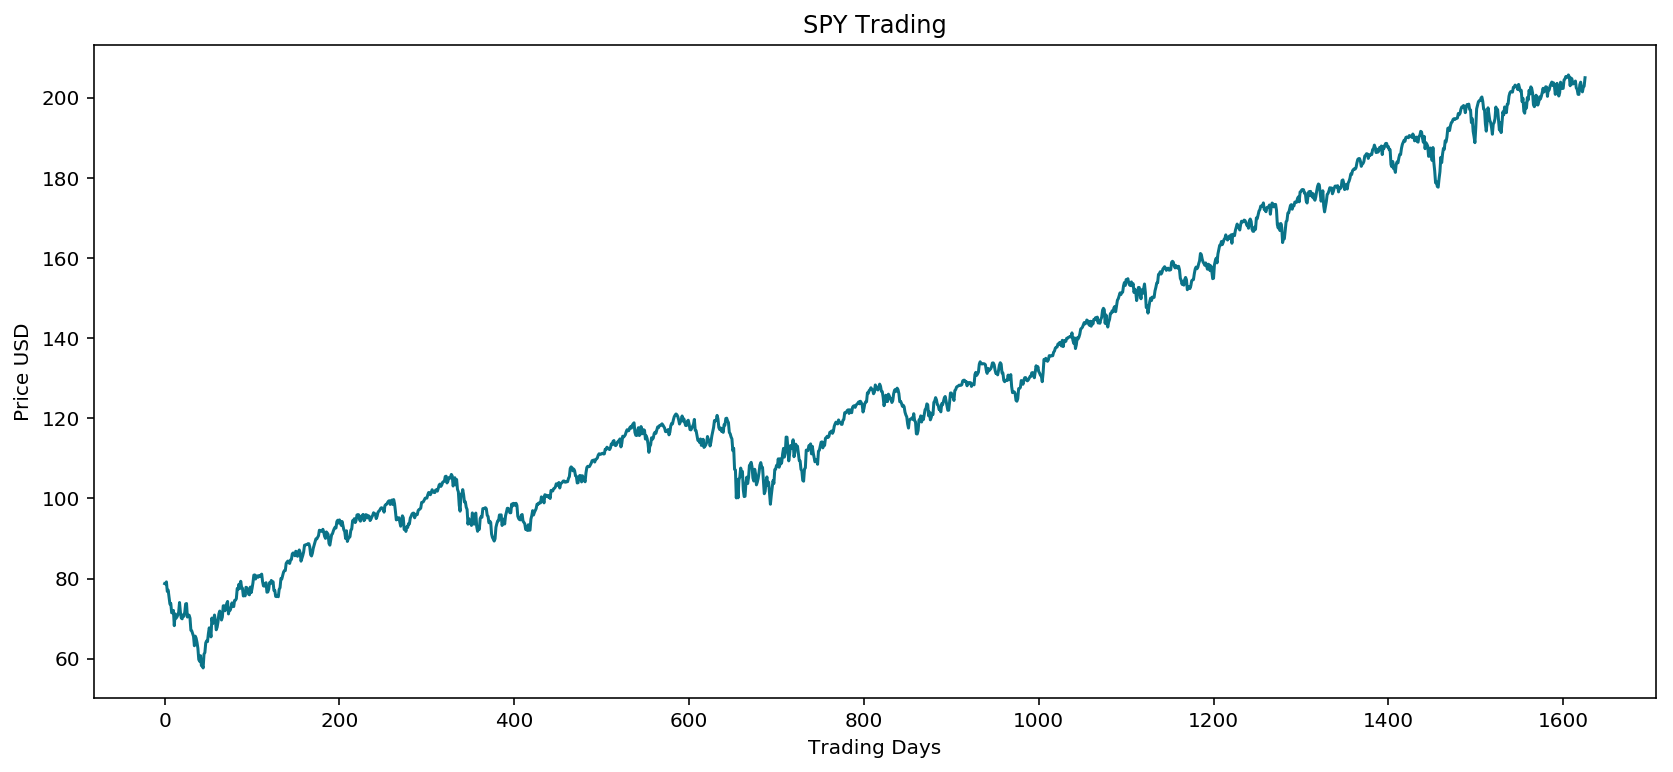

In [4]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [5]:
#Create numpy arrays for features and targets
X_all = []
y_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_all.append([(row['Item'])])
    y_all.append([(row['Adj_Close'])])

#pprint(X_all)
pprint(y_all)

[[78.738477],
 [78.64530500000001],
 [79.170456],
 [76.798813],
 [77.112211],
 [75.460528],
 [73.647917],
 [73.783443],
 [71.462625],
 [71.488034],
 [72.04706],
 [68.243967],
 [71.19158],
 [70.090459],
 [70.39538399999999],
 [70.878182],
 [71.59814399999999],
 [74.020606],
 [71.615088],
 [70.158221],
 [69.94646800000001],
 [70.929001],
 [70.58172900000001],
 [71.632025],
 [73.673333],
 [73.774971],
 [70.39538399999999],
 [70.81042],
 [70.861245],
 [70.09893100000001],
 [67.100498],
 [66.939563],
 [66.21960200000001],
 [65.575869],
 [63.229642000000005],
 [65.626695],
 [65.110015],
 [64.051247],
 [62.61979],
 [59.79923],
 [59.350313],
 [60.756361],
 [58.274606999999996],
 [58.376245],
 [57.690165],
 [61.129043],
 [61.52714],
 [63.949603],
 [64.449338],
 [64.254529],
 [66.21960200000001],
 [67.70187800000001],
 [66.86333499999999],
 [65.439545],
 [70.140001],
 [68.758014],
 [69.48312800000001],
 [70.899239],
 [69.619624],
 [67.21394699999999],
 [67.836689],
 [69.150429],
 [71.172224],
 [

In [6]:
# Scale function
def scale_range(X, input_range=[0.0,1.0], target_range=[0.0,1.0]):
    '''
    Scales a numpy array to a new target range
    X = array of numbers
    target_range = new target min and max, default (0.0, 1.0)
    '''
    orig_range = [X.min(axis=0),X.max(axis=0)]
    orig_range = [orig_range[0][0], orig_range[1][0]]
    X_std = (X - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    X_scaled = X_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return X_scaled, orig_range
    

In [7]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_bounds = [min(X_all), max(X_all)]
X_bounds = [X_bounds[0][0], X_bounds[1][0]]
y_bounds = [min(y_all), max(y_all)]
y_bounds = [y_bounds[0][0], y_bounds[1][0]]

X_scaled, X_range = scale_range(np.array(X_all), input_range=X_bounds, target_range=[-1.0, 1.0])
y_scaled, y_range = scale_range(np.array(y_all), input_range=y_bounds, target_range=[-1.0, 1.0])

pprint(y_scaled)
print(y_range)

array([[-0.71558208],
       [-0.71684108],
       [-0.70974491],
       ..., 
       [ 0.95768842],
       [ 0.96211482],
       [ 0.99062635]])
[57.690165, 205.69991200000001]


In [8]:
# Define Test/Train Split 80/20
tt_split = .20
tti_split = int(math.floor(len(stock_df['Item'])*tt_split))

# Set up training and test sets
X_train = X_scaled[:-tti_split]
X_test = X_scaled[-tti_split:]

y_train = y_scaled[:-tti_split]
y_test = y_scaled[-tti_split:]

#pprint(X_train)
#pprint(X_test)

# Create dataframe for all training, testing, and predicted sets
results_df = pd.DataFrame(columns=['Item', 'Actual', 'Actual_Scaled', 'Train', 'Test', 'Test_Scaled', 'Predicted', 'Predicted_Scaled'])
results_df['Item'] = stock_df['Item']
results_df['Actual'] = stock_df['Adj_Close']
results_df['Actual_Scaled'] = y_scaled.flatten()
results_df['Train'][:-tti_split] = y_train.flatten()
results_df['Test'][-tti_split:] = stock_df['Adj_Close'][-tti_split:]
results_df['Test_Scaled'][-tti_split:] = y_test.flatten()

pprint(results_df)


      Item      Actual  Actual_Scaled     Train     Test Test_Scaled  \
0        0   78.738477      -0.715582 -0.715582      NaN         NaN   
1        1   78.645305      -0.716841 -0.716841      NaN         NaN   
2        2   79.170456      -0.709745 -0.709745      NaN         NaN   
3        3   76.798813      -0.741792 -0.741792      NaN         NaN   
4        4   77.112211      -0.737557 -0.737557      NaN         NaN   
5        5   75.460528      -0.759876 -0.759876      NaN         NaN   
6        6   73.647917      -0.784369 -0.784369      NaN         NaN   
7        7   73.783443      -0.782538 -0.782538      NaN         NaN   
8        8   71.462625      -0.813898 -0.813898      NaN         NaN   
9        9   71.488034      -0.813555 -0.813555      NaN         NaN   
10      10   72.047060      -0.806001 -0.806001      NaN         NaN   
11      11   68.243967      -0.857390  -0.85739      NaN         NaN   
12      12   71.191580      -0.817560  -0.81756      NaN        

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [144]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

print(y_range)
# Create the predictions
predictions = regr.predict(X_test)
predictions_rescaled, re_range = scale_range(predictions, input_range=[-1.0,1.0], target_range=y_range)
print(re_range)
print(predictions)
print(predictions_rescaled)

# Store the predictions
results_df['Predicted_Scaled'][-tti_split:] = predictions.flatten()
results_df['Predicted'][-tti_split:] = predictions_rescaled.flatten()

pprint(results_df)

[57.690165, 205.69991200000001]
[0.40052456791933932, 0.70270989741169121]
[[ 0.40052457]
 [ 0.40145724]
 [ 0.40238991]
 [ 0.40332258]
 [ 0.40425525]
 [ 0.40518792]
 [ 0.40612059]
 [ 0.40705326]
 [ 0.40798593]
 [ 0.4089186 ]
 [ 0.40985128]
 [ 0.41078395]
 [ 0.41171662]
 [ 0.41264929]
 [ 0.41358196]
 [ 0.41451463]
 [ 0.4154473 ]
 [ 0.41637997]
 [ 0.41731264]
 [ 0.41824531]
 [ 0.41917798]
 [ 0.42011065]
 [ 0.42104332]
 [ 0.421976  ]
 [ 0.42290867]
 [ 0.42384134]
 [ 0.42477401]
 [ 0.42570668]
 [ 0.42663935]
 [ 0.42757202]
 [ 0.42850469]
 [ 0.42943736]
 [ 0.43037003]
 [ 0.4313027 ]
 [ 0.43223537]
 [ 0.43316804]
 [ 0.43410072]
 [ 0.43503339]
 [ 0.43596606]
 [ 0.43689873]
 [ 0.4378314 ]
 [ 0.43876407]
 [ 0.43969674]
 [ 0.44062941]
 [ 0.44156208]
 [ 0.44249475]
 [ 0.44342742]
 [ 0.44436009]
 [ 0.44529276]
 [ 0.44622544]
 [ 0.44715811]
 [ 0.44809078]
 [ 0.44902345]
 [ 0.44995612]
 [ 0.45088879]
 [ 0.45182146]
 [ 0.45275413]
 [ 0.4536868 ]
 [ 0.45461947]
 [ 0.45555214]
 [ 0.45648481]
 [ 0.45741

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


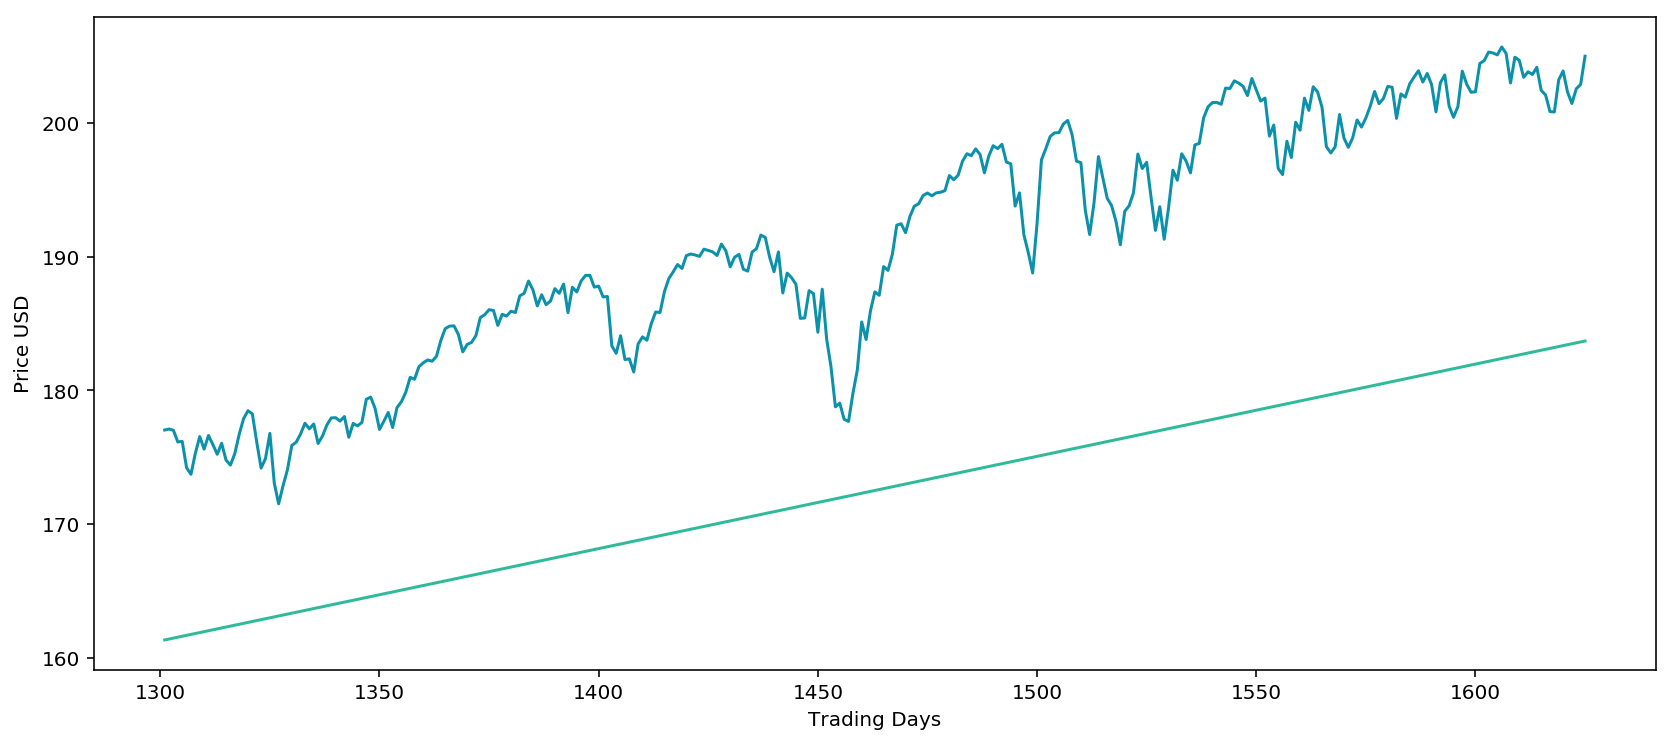

In [145]:
# Plot the training, testing, and predicted data
#plt.plot(results_df['Item'], results_df['Actual_Scaled'], '#0A7388')
plt.plot(results_df['Item'], results_df['Test'], '#0C91AB')
plt.plot(results_df['Item'], results_df['Predicted'], '#2FBA9C')

#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#actual.format_ydata = price
#plt.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [146]:
# Print the coefficients
print('Coefficients: %.3f' % regr.coef_)
# The mean squared error
print("Mean squared error: %.3f"
      % np.mean((predictions - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.3f' % regr.score(X_test, y_test))

Coefficients: 0.758
Mean squared error: 0.064
Variance score: -3.045
